In [1]:

import matplotlib.pyplot as plt
import numpy as np

# Optimization modeling library
from aqmodels import (
    HigherOrder,
    Linear,
    Model,
    Quadratic,
    Variable,
    Vtype,
)
from aqmodels.transformations import (
    AnalysisCache,
    MaxBiasAnalysis,
    PassManager,
    ActionType,
    IR,
)
from aqmodels.decorators import transform, analyse

# Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector

# Classical optimization
from scipy.optimize import minimize

# Import model data
from model.data import ConventionCenter, Schedule, SessionChair
from model.visualization import plot_floor_plan
from model.model import optimization_model

# Import utils (from last notebook)
from utils.sampling import cost_function, sample

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

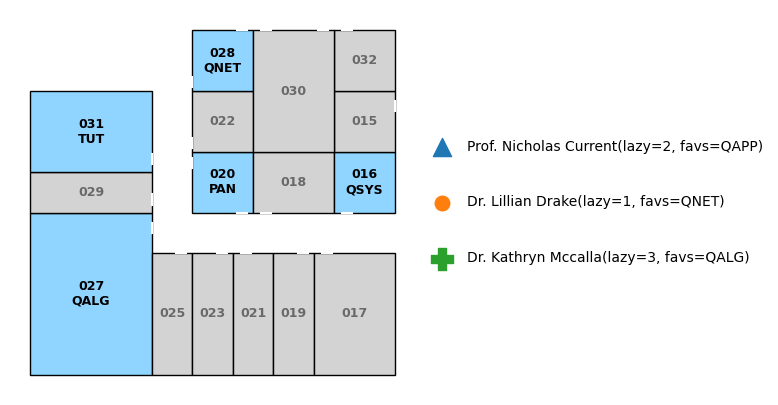

In [2]:
center = ConventionCenter.generate()
schedule = Schedule.random(5, center, seed=5)
chairs = SessionChair.random_chairs(3, seed=1)

satisfaction = 2

plot_floor_plan(center, schedule=schedule, chairs=chairs)

In [3]:
x, model = optimization_model(center, schedule, chairs, satisfaction=1)

## Identify and remove one-hot constriants

In [4]:
@analyse()
def identify_one_hot(model: Model, _: AnalysisCache):
    """Identifies one-hot constraints present in the model."""
    onehots: list[int | str] = []
    for i, constraint in enumerate(model.constraints):
        if not all(
            isinstance(k, Linear) and v == constraint.rhs
            for k, v in constraint.lhs.items()
        ):
            continue
        onehots.append(constraint.name or i)
    return onehots


@transform(requires=["identify-one-hot"], invalidates=["identify-one-hot"])
def remove_one_hot(model: Model, cache: AnalysisCache):
    """Removes one-hot constraints from the model."""
    one_hots: list[int | str] = cache["identify-one-hot"]

    if len(one_hots) == 0:
        return TransformationOutcome.nothing(model)

    # Extract one hot constraint information
    one_hot_info: dict[int | str, set[Variable]] = {}
    for i in one_hots:
        c = model.constraints[i]
        variables = [item.var for item, _ in c.lhs.items() if isinstance(item, Linear)]
        one_hot_info[i] = variables

    # Remove constraints
    for k, c in one_hot_info.items():
        model.constraints.remove(k)

    return model, ActionType.DidTransform, {"removed": one_hot_info}


pass_manager = PassManager([identify_one_hot, remove_one_hot, MaxBiasAnalysis()])

In [5]:
ir = pass_manager.run(model)
print(ir.model)

Model: Session chair assignment
Minimize
  15 * x_0_016 * x_0_028 + 8 * x_0_016 * x_0_020 + 10 * x_0_016 * x_0_031 
  + 9.6 * x_0_016 * x_0_027 + 7.5 * x_1_016 * x_1_028 + 4 * x_1_016 * x_1_020 
  + 5 * x_1_016 * x_1_031 + 4.8 * x_1_016 * x_1_027 + 22.5 * x_2_016 * x_2_028 
  + 12 * x_2_016 * x_2_020 + 15 * x_2_016 * x_2_031 + 14.4 * x_2_016 * x_2_027 
  + 7 * x_0_028 * x_0_020 + 7.8 * x_0_028 * x_0_031 + 10.8 * x_0_028 * x_0_027 
  + 3.5 * x_1_028 * x_1_020 + 3.9 * x_1_028 * x_1_031 + 5.4 * x_1_028 * x_1_027 
  + 10.5 * x_2_028 * x_2_020 + 11.7 * x_2_028 * x_2_031 
  + 16.2 * x_2_028 * x_2_027 + 2 * x_0_020 * x_0_031 + 3.8 * x_0_020 * x_0_027 
  + x_1_020 * x_1_031 + 1.9 * x_1_020 * x_1_027 + 3 * x_2_020 * x_2_031 
  + 5.7 * x_2_020 * x_2_027 + 3.4 * x_0_031 * x_0_027 + 1.7 * x_1_031 * x_1_027 
  + 5.1 * x_2_031 * x_2_027 - x_1_028 - x_2_027
Binary
  x_0_016 x_1_016 x_2_016 x_0_028 x_1_028 x_2_028 x_0_020 x_1_020 x_2_020 
  x_0_031 x_1_031 x_2_031 x_0_027 x_1_027 x_2_027


## Circuits


### W-State

In [6]:
def w_state(num: int):
    qc = QuantumCircuit(num)
    assert num >= 2
    if num == 2:
        qc.h(0)
        qc.x(1)
        qc.cx(0, 1)
    else:
        qc.x(0)
        for i in range(num - 1):
            angle = 2 * np.arccos(np.sqrt(1 / (num - i)))
            qc.cry(angle, i, i + 1)
            qc.cx(i + 1, i)
    return qc

In [7]:
probs = Statevector(w_state(6)).probabilities_dict()

print(" + ".join(f"{v:.3f} |{k}>" for k, v in probs.items()))

0.167 |000001> + 0.167 |000010> + 0.167 |000100> + 0.167 |001000> + 0.167 |010000> + 0.167 |100000>


In [8]:
def initial_state(ir: IR):
    """Implements the initial state for an arbitrary IR.

    Parameters
    ----------
    ir: IR
        The intermediate representation of the model transformation.

    Returns
    -------
    QuantumCircuit
    """
    qc = QuantumCircuit(len(ir.model.variables()))
    remove_one_hot = ir.cache["remove-one-hot"]
    if remove_one_hot is None:
        qc.h(qc.qubits)
    else:
        varmap = {v: i for i, v in enumerate(ir.model.variables())}
        one_hots = remove_one_hot["removed"]
        one_hot_vars = set(i for v in one_hots.values() for i in v)

        # Normal initial state
        if qc.num_qubits - len(one_hot_vars) > 0:
            qc.h([i for v, i in varmap.items() if v not in one_hot_vars])

        # W-state
        for w in one_hots.values():
            qc.compose(w_state(len(w)), [varmap[i] for i in w], inplace=True)

    return qc

In [9]:
initial_state(ir).draw()

┌───┐              ┌───┐                
 q_0: ┤ X ├──────■───────┤ X ├────────────────
      └───┘┌─────┴──────┐└─┬─┘           ┌───┐
 q_1: ─────┤ Ry(1.9106) ├──■───────■─────┤ X ├
           └────────────┘     ┌────┴────┐└─┬─┘
 q_2: ────────────────────────┤ Ry(π/2) ├──■──
      ┌───┐              ┌───┐└─────────┘     
 q_3: ┤ X ├──────■───────┤ X ├────────────────
      └───┘┌─────┴──────┐└─┬─┘           ┌───┐
 q_4: ─────┤ Ry(1.9106) ├──■───────■─────┤ X ├
           └────────────┘     ┌────┴────┐└─┬─┘
 q_5: ────────────────────────┤ Ry(π/2) ├──■──
      ┌───┐              ┌───┐└─────────┘     
 q_6: ┤ X ├──────■───────┤ X ├────────────────
      └───┘┌─────┴──────┐└─┬─┘           ┌───┐
 q_7: ─────┤ Ry(1.9106) ├──■───────■─────┤ X ├
           └────────────┘     ┌────┴────┐└─┬─┘
 q_8: ────────────────────────┤ Ry(π/2) ├──■──
      ┌───┐              ┌───┐└─────────┘     
 q_9: ┤ X ├──────■───────┤ X ├────────────────
      └───┘┌─────┴──────┐└─┬─┘           ┌───┐
q_10: ─────┤ Ry(1.9106) ├──■───────■─────┤ X ├
           └────────────┘     ┌────┴────┐└─┬─┘
q_11: ────────────────────────┤ Ry(π/2) ├──■──
      ┌───┐              ┌───┐└─────────┘     
q_12: ┤ X ├──────■───────┤ X ├────────────────
      └───┘┌─────┴──────┐└─┬─┘           ┌───┐
q_13: ─────┤ Ry(1.9106) ├──■───────■─────┤ X ├
           └────────────┘     ┌────┴────┐└─┬─┘
q_14: ────────────────────────┤ Ry(π/2) ├──■──
                              └─────────┘

In [10]:
m = Model()
y = [m.add_variable(f"y_{i}") for i in range(5)]
m.add_constraint(y[0] + y[2] + y[4] == 1)
initial_state(pass_manager.run(m)).draw()

┌───┐              ┌───┐                
q_0: ┤ X ├──────■───────┤ X ├────────────────
     ├───┤      │       └─┬─┘                
q_1: ┤ H ├──────┼─────────┼──────────────────
     └───┘┌─────┴──────┐  │             ┌───┐
q_2: ─────┤ Ry(1.9106) ├──■───────■─────┤ X ├
     ┌───┐└────────────┘          │     └─┬─┘
q_3: ┤ H ├────────────────────────┼───────┼──
     └───┘                   ┌────┴────┐  │  
q_4: ────────────────────────┤ Ry(π/2) ├──■──
                             └─────────┘

In [70]:
def rxy(beta: Parameter | float):
    """Implements single XY rotation.

    Parameters
    ----------
    beta: float | Parameter
        The beta parameter.

    Returns
    -------
    QuantumCircuit
    """
    qc = QuantumCircuit(2)
    qc.rxx(beta, 0, 1)
    qc.ryy(beta, 0, 1)
    return qc


def xy_mixer(num: int, beta: Parameter | float):
    """Implements the XY-ring-mixer.

    Parameters
    ----------
    num: int
        The number of qubits that are part of this ring mixer.
    beta: float | Parameter
        The beta parameter.

    Returns
    -------
    QuantumCircuit
    """
    qc = QuantumCircuit(num)
    assert num >= 2
    if num == 2:
        qc.compose(rxy(beta), (0, 1), inplace=True)
    else:
        uxy = rxy(beta)
        pairs = [(i, i + 1) for i in range(0, num - 1, 2)] + [
            (i, i + 1) for i in range(1, num - 1, 2)
        ]
        pairs.append((0, num - 1))
        for p in pairs:
            qc.compose(uxy, p, inplace=True)

    return qc


def combined_mixer(ir: IR, beta: Parameter | float):
    """Implements the combined mixer.

    Automatically applies normal X-mixer or combined mixer depending on IR

    Parameters
    ----------
    ir: IR
        The intermediate representation of the model transformation.
    beta: float | Parameter
        The beta parameter.

    Returns
    -------
    QuantumCircuit
    """
    remove_one_hot = ir.cache["remove-one-hot"]
    if remove_one_hot is None:
        return rx_mixer_layer(len(ir.model.variables()), beta)

    qc = QuantumCircuit(len(ir.model.variables()))
    varmap = {v: i for i, v in enumerate(ir.model.variables())}

    one_hots = remove_one_hot["removed"]
    one_hot_vars = set(i for v in one_hots.values() for i in v)

    # Normal initial state
    if qc.num_qubits - len(one_hot_vars) > 0:
        qc.compose(
            rx_mixer_layer(qc.num_qubits - len(one_hot_vars), beta),
            [i for v, i in varmap.items() if v not in one_hot_vars],
            inplace=True,
        )

    # W-state
    for w in one_hots.values():
        qc.compose(xy_mixer(len(w), beta), [varmap[i] for i in w], inplace=True)

    return qc

In [71]:
qc = xy_rot(Parameter("b"))
import qiskit.quantum_info as qi

op = qi.Operator(rxy(0.5)).to_matrix()
print(op.round(3))
qc = QuantumCircuit(1)
qc.rx(2 * 0.5, 0)
op = qi.Operator(qc).to_matrix()
print(op.round(3))

[[1.   +0.j    0.   +0.j    0.   +0.j    0.   +0.j   ]
 [0.   +0.j    0.878+0.j    0.   -0.479j 0.   +0.j   ]
 [0.   +0.j    0.   -0.479j 0.878+0.j    0.   +0.j   ]
 [0.   +0.j    0.   +0.j    0.   +0.j    1.   +0.j   ]]
[[0.878+0.j    0.   -0.479j]
 [0.   -0.479j 0.878+0.j   ]]


In [73]:
xy_mixer(6, Parameter("b")).draw()

┌─────────┐┌─────────┐           ┌─────────┐           ┌─────────┐
q_0: ┤0        ├┤0        ├───────────┤0        ├───────────┤0        ├
     │  Rxx(b) ││  Ryy(b) │┌─────────┐│         │┌─────────┐│         │
q_1: ┤1        ├┤1        ├┤0        ├┤         ├┤0        ├┤         ├
     ├─────────┤├─────────┤│  Rxx(b) ││         ││  Ryy(b) ││         │
q_2: ┤0        ├┤0        ├┤1        ├┤         ├┤1        ├┤         ├
     │  Rxx(b) ││  Ryy(b) │├─────────┤│  Rxx(b) │├─────────┤│  Ryy(b) │
q_3: ┤1        ├┤1        ├┤0        ├┤         ├┤0        ├┤         ├
     ├─────────┤├─────────┤│  Rxx(b) ││         ││  Ryy(b) ││         │
q_4: ┤0        ├┤0        ├┤1        ├┤         ├┤1        ├┤         ├
     │  Rxx(b) ││  Ryy(b) │└─────────┘│         │└─────────┘│         │
q_5: ┤1        ├┤1        ├───────────┤1        ├───────────┤1        ├
     └─────────┘└─────────┘           └─────────┘           └─────────┘

In [57]:
def cost_layer_adv(ir: IR, gamma: Parameter | float):
    """Implements a single QAOA cost operation.

    Parameters
    ----------
    ir: IR
        The intermediate representation containing the transformed objective function
        and model metadata
    gamma: Parameter | Float
        Cost parameter (controls problem-specific rotations)

    Returns
    -------
    QuantumCircuit
        A single QAOA cost layer
    """
    qc = QuantumCircuit(len(ir.model.variables()))

    max_bias = ir.cache["max-bias"].val

    # Mapping from variables to qubit indices
    varmap = {v: i for i, v in enumerate(ir.model.variables())}

    for item, val in ir.model.objective.items():
        angle = val * gamma / max_bias
        match item:
            case Linear(v):
                # Linear terms: single-qubit phase gate
                qc.p(angle, varmap[v])
            case Quadratic(v1, v2):
                # Quadratic terms: two-qubit controlled-phase gate applied to |11>
                qc.cp(angle, varmap[v1], varmap[v2])
            case HigherOrder(vs):
                # HigherOrder terms: muti-qubit controlled-phase gate applied to |11..11>
                qc.mcp(angle, [varmap[v] for v in vs[:-1]], varmap[vs[-1]])

    return qc


def qaoa_layer_adv(
    ir: IR, beta: Parameter | float, gamma: Parameter | float
) -> QuantumCircuit:
    """Implements a single advanced QAOA layer consisting of cost and mixer operations.

    Parameters
    ----------
    ir: IR
        The intermediate representation containing the transformed objective function
        and model metadata
    beta: Parameter | Float
        Mixer parameter (controls X-rotations)
    gamma: Parameter | Float
        Cost parameter (controls problem-specific rotations)

    Returns
    -------
    QuantumCircuit
        A single QAOA layer
    """

    qc = cost_layer_adv(ir, gamma)
    qc = qc.compose(combined_mixer(ir, beta))
    assert qc is not None

    return qc


def qaoa_circ_adv(ir: IR, reps: int = 1) -> QuantumCircuit:
    """Generates a complete advanced QAOA circuit with specified number of layers.

    Parameters
    ----------
    ir: IR
        The intermediate representation containing the transformed objective function
        and model metadata
    reps: int
        Number of QAOA layers (p parameter)

    Returns
    -------
    QuantumCircuit
        Complete QAOA circuit with measurements
    """
    # Verify the model is suitable for QAOA
    assert ir.model.num_constraints == 0, "QAOA requires unconstrained problems"
    assert all(v.vtype == Vtype.Binary for v in ir.model.variables()), (
        "All variables must be binary"
    )

    # Start with equal superposition state |+⟩^⊗n \otimes |W>
    qc = initial_state(ir)

    # Create parameter templates for a single layer
    beta = Parameter("beta")
    gamma = Parameter("gamma")
    layer_circ = qaoa_layer_adv(ir, beta, gamma)

    # Create individual parameters for each layer
    betas = [Parameter(f"beta_{p}") for p in range(reps)]
    gammas = [Parameter(f"gamma_{p}") for p in range(reps)]

    # Add all QAOA layers
    for beta_p, gamma_p in zip(betas, gammas):
        # Substitute the template parameters with layer-specific ones
        layer_instance = layer_circ.assign_parameters({beta: beta_p, gamma: gamma_p})
        qc = qc.compose(layer_instance)
        assert qc is not None

    # Add measurements to all qubits
    qc.measure_all()
    return qc

In [ ]:
qaoa_circ_adv(ir).draw("mpl", scale=0.5, fold=100)

In [ ]:
best = None
final_solution = None
all_logs = {}

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))
# ax.axhline(1, color="k", linestyle="dashed", label="optimal value")
# ax.axhline(0.878, color="gray", linestyle="dashed", label="Goemans-Williamson approximation ratio")
ax.set_xlabel("Iteration")
ax.set_ylabel(r"Energy Expectation $\langle H_C \rangle$")
ax.set_title("QAOA Optimization Progress for Different Circuit Depths")
plt.draw()

# Run QAOA for different numbers of layers
for p in range(1, 5):
    print(f"=== Running optimization for p={p} layers ===")

    current_it = 1

    def progress_callback(*args):
        """Callback function to print optimization progress."""
        global current_it
        if current_it % 5 == 0:
            print(f"Iteration {current_it}: Energy = {all_logs[p][-1]:.3f}")
        current_it += 1

    # Create QAOA circuit with p layers
    circ = qaoa_circ_adv(ir, p)
    all_logs[p] = []

    print(f"Circuit depth: {circ.depth()}, Parameters: {len(circ.parameters)}")

    # Run classical optimization
    initial_params = np.concat(
        [np.linspace(0.5, 0, p), np.linspace(0, 0.5, p)]
    )  # p beta parameters + p gamma parameters

    result = minimize(
        cost_function,  # Function to minimize
        initial_params,  # Initial parameters
        args=(ir.model, circ, all_logs[p], 10000),  # Additional arguments
        method="COBYLA",  # Optimization algorithm
        options={"rhobeg": 0.1},  # COBYLA-specific options
        callback=progress_callback,  # Progress monitoring
    )

    # Plot the optimization trajectory
    ax.plot(all_logs[p], label=f"p={p} ({len(all_logs[p])} iterations)")

    final_solution = sample(model, circ, result.x)
    best = final_solution.best()

    print("-------------------------")
    print(f"Energy: {result.fun:.3f}")
    print(f"Best objective value: {best.obj_value}")
    print()


print("\n=== Final Results ===")
print(f"Best objective value: {best.obj_value}")
print(f"Final energy: {result.fun:.3f}")

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show();

In [ ]:
final_solution.feasibility_ratio()

In [ ]:
print(final_solution)